# 애플 앱스토어 평점 예측

- Kaggle에 있는 Apple AppStore 데이터를 이용하여 데이터 결측치 처리 및 변수 변환 등 데이터를 전처리한 뒤 평점 예측 모델을 만든다. 

- Machine learning에서 필요한 scikit-learn(사이킷런) 라이브러리를 바탕으로 로지스틱 회귀모형, KNN, decision tree, random forest를 이용해 모델을 수립하였다.  
- 모델 수립 후, K-fold 교차 검증을 활용하여 정확도의 평균을 구하고, 가장 정확도가 높은 모델을 대표 모델로 선정한 뒤 실제로 예측한다.

### 데이터 전처리

In [1]:
# csv 에서 데이터를 읽어와 행렬 객체로 만들 수 있는 모듈
# 다양한 데이터 전처리
import pandas as pd
# Numpy는 과학 연산을 위한 라이브러리
# 다차원 배열과 이런 배열을 처리
import numpy as np
# 시각화 라이브러리
import matplotlib.pyplot as plt

In [2]:
# 데이터를 읽어온다
modeldata = pd.read_csv('AppleStore.csv')

In [3]:
# 데이터 정보 확인
modeldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
Unnamed: 0          7197 non-null int64
id                  7197 non-null int64
track_name          7197 non-null object
size_bytes          7197 non-null int64
currency            7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
rating_count_ver    7197 non-null int64
user_rating         7197 non-null float64
user_rating_ver     7197 non-null float64
ver                 7197 non-null object
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
vpp_lic             7197 non-null int64
dtypes: float64(3), int64(9), object(5)
memory usage: 955.9+ KB


In [4]:
# 필요없는 정보 drop
drop_list= ['id','currency','rating_count_ver','user_rating_ver','ver','cont_rating','sup_devices.num','ipadSc_urls.num','lang.num','vpp_lic','size_bytes']
modeldata = modeldata.drop(drop_list,axis=1)

In [5]:
# 장르는 group으로 만들기 위해 숫자로 바꾸어준다
category_map = {}
category_list = []
i = 0
for data in modeldata['prime_genre']:
    if data not in category_map.keys():
        category_list.append(data)
        category_map[data] = i
        i += 1
        
print(category_map)

modeldata['prime_genre'] = modeldata['prime_genre'].map(category_map)

{'Games': 0, 'Productivity': 1, 'Weather': 2, 'Shopping': 3, 'Reference': 4, 'Finance': 5, 'Music': 6, 'Utilities': 7, 'Travel': 8, 'Social Networking': 9, 'Sports': 10, 'Business': 11, 'Health & Fitness': 12, 'Entertainment': 13, 'Photo & Video': 14, 'Navigation': 15, 'Education': 16, 'Lifestyle': 17, 'Food & Drink': 18, 'News': 19, 'Book': 20, 'Medical': 21, 'Catalogs': 22}


In [6]:
# 장르가 숫자로 잘 변환 되었는지 확인
modeldata.head(5) 

,Unnamed: 0,track_name,price,rating_count_tot,user_rating,prime_genre
0,1,PAC-MAN Premium,3.99,21292,4.0,0
1,2,Evernote - stay organized,0.00,161065,4.0,1
2,3,"WeatherBug - Local Weather, Radar, Maps, Alerts",0.00,188583,3.5,2
3,4,"eBay: Best App to Buy, Sell, Save! Online Shop...",0.00,262241,4.0,3
4,5,Bible,0.00,985920,4.5,4


In [7]:
# 결측값 확인
modeldata.isnull().sum()

Unnamed: 0          0
track_name          0
price               0
rating_count_tot    0
user_rating         0
prime_genre         0
dtype: int64

In [8]:
# 데이터 정보 확인
modeldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 6 columns):
Unnamed: 0          7197 non-null int64
track_name          7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
user_rating         7197 non-null float64
prime_genre         7197 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 337.4+ KB


In [9]:
# 전처리된 데이터 저장
modeldata.to_csv('apple_new_data.csv')

### 예측 모델

In [10]:
# csv 에서 데이터를 읽어와 행렬 객체로 만들 수 있는 모듈
# 다양한 데이터 전처리
import pandas as pd
# 데이터를 학습용과 테스트용으로 나눌 수 있는 함수
from sklearn.model_selection import train_test_split
# 사용할 모델들
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
# KFold 교차 검증을 위한 모듈들
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import numpy as np
import collections

##### 학습 데이터와 테스트 데이터를 7:3으로 나눈다

In [11]:
train, test = train_test_split(modeldata, test_size=0.3)

##### 결과 데이터 추출

In [12]:
target = train['user_rating']
target = target.astype(int)
train = train.drop(['track_name','user_rating'], axis=1)

##### 평점 예측 모델 선택하기

In [13]:
# 모델 객체 생성
model1 = LogisticRegression(C=1000.0, random_state=0)
model2 = KNeighborsClassifier(n_neighbors = 15)
model3 = DecisionTreeClassifier()
model4 = RandomForestClassifier(n_estimators=15)
model5 = GaussianNB()
model6 = SVC(C=1, kernel='rbf', coef0=1)
model7 = XGBClassifier()

# Fold 생성
folds = KFold(n_splits=10, shuffle=True, random_state=0)

# 교차 검증한다 (rating)
score1 = cross_val_score(model1, train, target, cv=folds, n_jobs=1, scoring='accuracy')
score2 = cross_val_score(model2, train, target, cv=folds, n_jobs=1, scoring='accuracy')
score3 = cross_val_score(model3, train, target, cv=folds, n_jobs=1, scoring='accuracy')
score4 = cross_val_score(model4, train, target, cv=folds, n_jobs=1, scoring='accuracy')
score5 = cross_val_score(model5, train, target, cv=folds, n_jobs=1, scoring='accuracy')
score6 = cross_val_score(model6, train, target, cv=folds, n_jobs=1, scoring='accuracy')
score7 = cross_val_score(model7, train, target, cv=folds, n_jobs=1, scoring='accuracy')

# 각 모델별 정확도 평균을 구한다 (rating)
avg1 = round(np.mean(score1) * 100, 2)
avg2 = round(np.mean(score2) * 100, 2)
avg3 = round(np.mean(score3) * 100, 2)
avg4 = round(np.mean(score4) * 100, 2)
avg5 = round(np.mean(score5) * 100, 2)
avg6 = round(np.mean(score6) * 100, 2)
avg7 = round(np.mean(score7) * 100, 2)

print('정확도 평균: ', f'{avg1},{avg2},{avg3},{avg4},{avg5},{avg6},{avg7}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default so

정확도 평균:  71.85,64.11,61.88,68.73,40.88,59.72,72.86


In [14]:
# 정확도 평균이 가장 높게 나온 modle7으로 학습
model7.fit(train, target)
print('학습완료')

학습완료


##### 예측모델 사용하기

In [15]:
rating = test['user_rating']
genre = test['prime_genre']
test = test.drop(['track_name','user_rating'],axis=1)
                  
# 예측 결과 계산
y_pred = model7.predict(test)

In [16]:
# 평점 예측 결과를 DataFrame로 만든다
rating_predictive_model = pd.DataFrame({'Category': genre, 'Rating':y_pred})

In [17]:
# 카테고리로 group하여 예측한 평점의 평균을 반환
rating_predictive_model = round(rating_predictive_model.groupby(['Category'], as_index=False).mean(),1)
# 예측한 평점이 높은 순으로 정렬
rating_predictive_model = rating_predictive_model.sort_values('Rating', ascending=False)

In [18]:
# category_map의 key,value 값을 바꿈
inverse_category_map = {v: k for k, v in category_map.items()}

# 현재 카테고리가 숫자로 되어 있으므로 다시 문자로 변경
rating_predictive_model['Category'] = rating_predictive_model['Category'].map(inverse_category_map)
rating_predictive_model

,Category,Rating
22,Catalogs,4.0
21,Medical,4.0
11,Business,3.9
1,Productivity,3.8
2,Weather,3.8
6,Music,3.8
3,Shopping,3.7
14,Photo & Video,3.7
7,Utilities,3.6
12,Health & Fitness,3.5


In [19]:
# 카테고리별 평점 예측 결과를 저장
rating_predictive_model.to_csv('AppleStore_rating_predictive_model.csv')

In [9]:
# 데이터를 읽어온다
rating_predictive_model = pd.read_csv('AppleStore_rating_predictive_model.csv')

In [11]:
print(rating_predictive_model.describe())

       Unnamed: 0    Rating
count    23.00000  23.00000
mean     11.00000   3.40000
std       6.78233   0.47194
min       0.00000   2.30000
25%       5.50000   3.30000
50%      11.00000   3.50000
75%      16.50000   3.75000
max      22.00000   4.00000


##### 카테고리별 평점 예측 모델 시각화

In [20]:
import matplotlib.font_manager as fm
import seaborn as sns

In [21]:
# 폰트 설정
font_name = 'c:/Windows/Fonts/NGULIM.TTF'
font_pro = fm.FontProperties(fname=font_name)
font_family = font_pro.get_name()

plt.rcParams['font.family'] = font_family

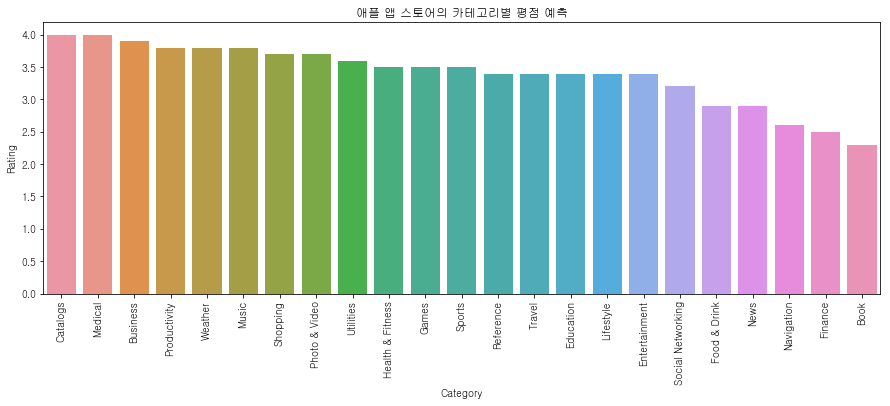

In [23]:
plt.figure(figsize=(15,5))
sns.barplot(x='Category',y='Rating',data=rating_predictive_model,ci=None)
plt.title("애플 앱 스토어의 카테고리별 평점 예측")
plt.xticks(rotation=90)

# 그래프 저장
fig = plt.gcf()
fig.savefig('apple_predictive_model.png', dpi=fig.dpi)